In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Input, BatchNormalization, Dense
from keras.layers.core import RepeatVector, Permute
from scipy import ndimage, misc
from keras.optimizers import Adam
from keras.layers import  Flatten,Dense
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU
import random
from keras.layers import Concatenate
from keras.models import load_model

from keras.layers import  Flatten,Dense


Using TensorFlow backend.


In [ ]:
#Import the dataset of images
X = []
names = os.listdir('Datasets\Train_new')
names.sort()
print(names)
for filename in names:
    #print(filename)
    img = cv2.imread('Datasets\Train_new'+filename, cv2.IMREAD_UNCHANGED)
    scale_percent = 25 # percent of original size
    width = int(img.shape[1] * (scale_percent-6)/ 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    #print(dim)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
   # plt.imshow(img)
    X.append(resized)
    #plt.show()

X = np.array(X, dtype=float)
print("##################")
# for ele in X:
#   plt.imshow(ele)
#   plt.show()
Xtrain = 1.0/255*X
Xtrain.shape

['0000000000.png', '0000000001.png', '0000000002.png', '0000000003.png', '0000000004.png', '0000000005.png', '0000000006.png', '0000000007.png', '0000000008.png', '0000000009.png', '0000000010.png', '0000000011.png', '0000000012.png', '0000000013.png', '0000000014.png', '0000000015.png', '0000000016.png', '0000000017.png', '0000000018.png', '0000000019.png', '0000000020.png', '0000000021.png', '0000000022.png', '0000000023.png', '0000000024.png', '0000000025.png', '0000000026.png', '0000000027.png', '0000000028.png', '0000000029.png', '0000000030.png', '0000000031.png', '0000000032.png', '0000000033.png', '0000000034.png', '0000000035.png', '0000000036.png', '0000000037.png', '0000000038.png', '0000000039.png', '0000000040.png', '0000000041.png', '0000000042.png', '0000000043.png', '0000000044.png', '0000000045.png', '0000000046.png', '0000000047.png', '0000000048.png', '0000000049.png', '0000000050.png', '0000000051.png', '0000000052.png', '0000000053.png', '0000000054.png', '00000000

(453, 128, 264)

(453, 128, 264, 1)
1.15.2


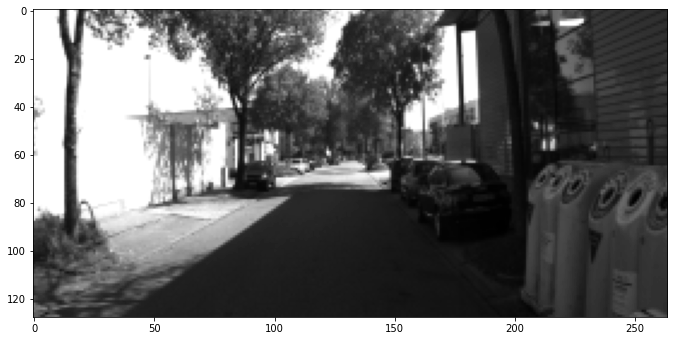

In [ ]:
plt.figure(figsize=[25,25])

plt.subplot(121)
curr_img = np.reshape(Xtrain[0], (128,264))
#curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
Xtrain= Xtrain.reshape(-1, 128,264, 1)
print(Xtrain.shape)
print(tf.__version__)

In [ ]:
train_X = Xtrain[:400]
valid_X = Xtrain[400:]
train_ground = Xtrain[:400]
valid_ground = Xtrain[400:]
print(train_X.shape)
print(valid_X.shape)
print(train_ground.shape)
print(valid_ground.shape)

(400, 128, 264, 1)
(53, 128, 264, 1)
(400, 128, 264, 1)
(53, 128, 264, 1)


In [ ]:
batch_size = 1
epochs = 200
inChannel = 1
x, y = 128, 264
input_img = Input(shape = ((x, y, inChannel)))
input_img1 = Input(shape = ((x, y, inChannel)))
input_img2 = Input(shape = ((x, y, inChannel)))
input_img3 = Input(shape = ((x, y, inChannel)))
input_img4 = Input(shape = ((x, y, inChannel)))
decoder_input= Input(shape = ((16,33,256)))

In [ ]:
#Define the encoder and decoder architecture
def encoder(input_img,input_img1,input_img2,input_img3,input_img4):
    init = RandomNormal(stddev=0.02)
    merged = Concatenate()([input_img1, input_img2])
    merged = Concatenate()([merged, input_img3])
    merged = Concatenate()([merged, input_img4])
    conv1 = Conv2D(128, (7, 7), padding='same', kernel_initializer=init)(merged) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #64 x 132 x 128
    pool1 = BatchNormalization()(pool1)
    pool1 = LeakyReLU(alpha=0.2)(pool1)
    conv2 = Conv2D(128, (3, 3), padding='same', kernel_initializer=init)(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #32 x 66 x 128
    pool2 = BatchNormalization()(pool2) 
    pool2 = LeakyReLU(alpha=0.2)(pool2)
    conv3 = Conv2D(256, (3, 3), padding='same', kernel_initializer=init)(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #16 x 33 x 256
    pool3 = BatchNormalization()(pool3) 
    pool3 = LeakyReLU(alpha=0.2)(pool3) 
    encod = Model([input_img1,input_img2,input_img3,input_img4],pool3)
    return encod

def decoder_old(decoder_input):
    init = RandomNormal(stddev=0.02)
    conv5 = Conv2D(256, (3, 3), padding='same', kernel_initializer=init)(decoder_input) 
    up1 = UpSampling2D((2,2))(conv5) #32 x 66 x 256
    up1 = BatchNormalization()(up1) 
    up1 = LeakyReLU(alpha=0.2)(up1)
    conv6 = Conv2D(256, (3, 3), padding='same', kernel_initializer=init)(up1)  
    up2 = UpSampling2D((2,2))(conv6) #64 x 132 x 256
    up2 = BatchNormalization()(up2) 
    up2 = LeakyReLU(alpha=0.2)(up2)
    conv7 = Conv2D(128, (3, 3), padding='same', kernel_initializer=init)(up2) 
    # conv7 = BatchNormalization()(conv7) 
    up3 = UpSampling2D((2,2))(conv7) # 128 x 264 x 128
    up3 = BatchNormalization()(up3) 
    up3 = BatchNormalization()(up3) 
    decoded = Conv2D(1, (7, 7), activation='tanh', padding='same', kernel_initializer=init)(up3)
    decod = Model(decoder_input, decoded)
    return decod


In [ ]:
print(input_img)
# ec=encoder(input_img)
code = encoder(input_img,input_img1, input_img2,input_img3,input_img4)
code.summary()
# encoder = Model([input_img1,input_img2,input_img3,input_img4],ec)
decode=decoder_old(decoder_input)
#encoder.summary()
decode.summary()

Tensor("input_1:0", shape=(?, 128, 264, 1), dtype=float32)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 264, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128, 264, 1)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 264, 2)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________

In [ ]:
temp=code([input_img1,input_img2,input_img3,input_img4])
dec_output=decode(temp)
auto_encoder=Model([input_img1,input_img2,input_img3,input_img4],dec_output)
opt = Adam(lr=0.0002, beta_1=0.5)
auto_encoder.compile(loss='mean_squared_error', optimizer = opt)

In [ ]:
def concat_input(list_image):
  list_concat=[]
  merged = Concatenate()([list_image[0], list_image[1]])
  merged = Concatenate()([merged, list_image[2]])
  merged = Concatenate()([merged, list_image[3]])
  print(merged.shape)

auto_encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 264, 1)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 128, 264, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128, 264, 1)  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 128, 264, 1)  0                                            
____________________________________________________________________________________________

In [ ]:
train_x1=Xtrain[:398]
train_x2=Xtrain[1:399]
train_x3=Xtrain[2:400]
train_x4=Xtrain[3:401]
y_train=Xtrain[4:402]
test_x1 =Xtrain[402:406]
test_x2 =Xtrain[403:407]
test_x3 =Xtrain[404:408]
test_x4 =Xtrain[405:409]
train_x1=Xtrain[:398]
train_x2=Xtrain[1:399]
train_x3=Xtrain[2:400]
train_x4=Xtrain[3:401]
print(train_x1.shape)

(398, 128, 264, 1)


In [ ]:
#Train the autoencoder
auto_encoder=load_model('/gdrive/My Drive/Frame_prediction_kitti/auto_encoder_input_concat_500ep.h5')
autoencoder_train = auto_encoder.fit([train_x1,train_x2,train_x3,train_x4], y_train,epochs=epochs,verbose=1)


In [ ]:
# auto_encoder.save('/gdrive/My Drive/Frame_prediction_kitti/auto_encoder_input_combined.h5')
pred=auto_encoder.predict([test_x1,test_x2,test_x3,test_x4])

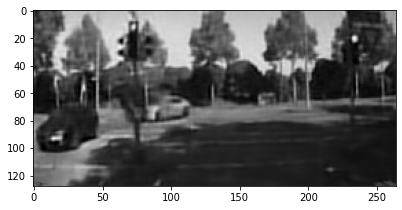

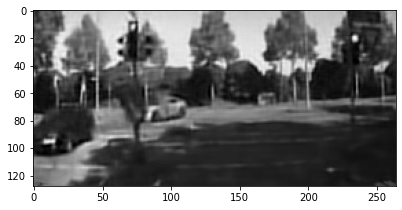

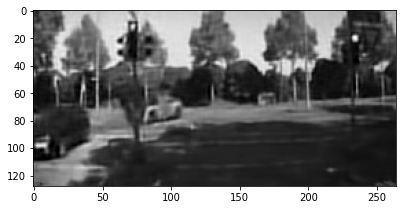

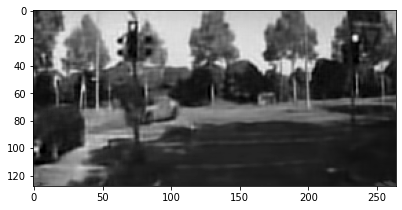

In [ ]:
for i in range(0,4):
    plt.figure(figsize=(100, 200))
    plt.subplot(2,13,1)
    plt.imshow(pred[(i),...,0],cmap='gray')
    plt.show()

In [ ]:
#DISCRIMINATOR 
input_img_disc = Input(shape = (128, 264, 1))
def discriminator(input_img_disc):
    init = RandomNormal(stddev=0.02)
    conv1 = Conv2D(64, (4, 4),strides=(2,2), activation='relu', padding='same',kernel_initializer=init)(input_img_disc) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(128, (4, 4),strides=(2,2), activation='relu', padding='same',kernel_initializer=init)(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(256, (4, 4),strides=(2,2), activation='relu', padding='same',kernel_initializer=init)(pool2) 
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv5=Conv2D(4,(1,1),activation='relu',padding='same',kernel_initializer=init)(pool3)
    flat=Flatten()(conv5)
    predi = Dense(1, activation='sigmoid',kernel_initializer=init)(flat)
    return predi



def call_disc(input_img_disc):
  discriminato = Model(input_img_disc, discriminator(input_img_disc))
  opt = Adam(lr=0.00002, beta_1=0.5)
  discriminato.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  #discriminator.summary()
  return discriminato

In [ ]:
#Define the GAN Model
def define_gan(g_model, d_model, input_img1,input_img2,input_img3,input_img4):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect the source images to the generator input
	gen_out = g_model([input_img1,input_img2,input_img3,input_img4])
	# connect the source input and generator output to the discriminator input
	dis_out = d_model(gen_out)
	return dis_out

def call_gan(g_model,d_model,input_img1,input_img2,input_img3,input_img4):
	model=Model([input_img1,input_img2,input_img3,input_img4],define_gan(g_model,d_model,input_img1,input_img2,input_img3,input_img4))
	opt = Adam(lr=0.00007, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt,loss_weights=[0.5])
	print(model.summary)
	return model  

In [ ]:

def generate_real_samples(Xtrain,number, batch_size):
  list_real_sample = []
  for i in range(number,number+batch_size):
    list_real_sample.append(Xtrain[i])
  real_sample=np.asarray(list_real_sample)
  li=[.95]*len(real_sample)
  y=np.asarray(li)
  #y = np.ones(len(real_sample))
  return real_sample, y


def generate_fake_samples(g_model, Xtrain,number,batch_size):
  z1=Xtrain[number:number+batch_size]
  z2=Xtrain[number+1:number+batch_size+1]
  z3=Xtrain[number+2:number+batch_size+2]
  z4=Xtrain[number+3:number+batch_size+3]
  final_pred = g_model.predict([z1,z2,z3,z4])
  print("Predicted Output for the sequence is ")
  # for i in range(0,4):
  #   plt.figure(figsize=(100, 100))
  #   plt.subplot(2,13,1)
  #   plt.imshow(final_pred[(i),...,0],cmap='gray')
  #   plt.show()
  li=[.05]*len(final_pred)
  y=np.asarray(li)
  #y = np.zeros(len(final_pred))
  return final_pred, y

In [ ]:
#Define the training of the GAN 
def train(g_model, d_model, gan_model, Xtrain, n_epochs=50, n_batch=4):
  bat_per_epo = int(len(Xtrain)/ n_batch)
  half_batch = int(n_batch / 2)
	# manually enumerate epochs
  history = []
  for i in range(n_epochs):
		# enumerate batches over the training set
    print("EPOCH NUMBER ",i)
    for j in range(bat_per_epo):
      number=random.randint(0,50)
      number2=random.randint(0,50)
      print(number)
			# get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(Xtrain,number+4, n_batch)
      X_real2, y_real2 = generate_real_samples(Xtrain,number2+4, n_batch)
      #print(X_real.shape,y_real.shape)
			# update discriminator model weights
      print(X_real.shape,y_real.shape)
      d_loss1 = d_model.train_on_batch(X_real,y_real)
      d_loss11 = d_model.train_on_batch(X_real2,y_real2)
      print("D_loss1:",d_loss1)
      print("D_loss11:",d_loss11)
      print("Discriminator prediction for real images ",d_model.predict(X_real))
			# generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, Xtrain,number, n_batch)
      X_fake2, y_fake2 = generate_fake_samples(g_model, Xtrain,number2, n_batch)
			# update discriminator model weights
      for k in range(0,4):
        plt.figure(figsize=(100, 100))
        plt.subplot(2,13,1)
        plt.imshow(X_fake[(k),...,0],cmap='gray')
        plt.show()
      d_loss_fake2= d_model.train_on_batch(X_fake, y_fake)
      d_loss_fake22= d_model.train_on_batch(X_fake2, y_fake2)
      discriminator_loss = 0.5 * np.add(d_loss_fake2, d_loss1)
      print("D_loss_fake1:",d_loss_fake2)
      print("D_loss_fake11:",d_loss_fake22)
      print("Dicriminator prediction for fake images ",d_model.predict(X_fake))
      # else:
      #   print("SKIPPED D TRAINING")
			#print(discriminator.predict(X_fake))
			# prepare points in latent space as input for the generator
			#[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
      li=[.95]*(n_batch)
      y_gan=np.asarray(li)
      # print("OOOO",y_gan.shape)
      #y_gan = np.ones(n_batch)
			# update the generator via the discriminator's error
      z1=Xtrain[number:number+n_batch]
      z2=Xtrain[number+1:number+n_batch+1]
      z3=Xtrain[number+2:number+n_batch+2]
      z4=Xtrain[number+3:number+n_batch+3]
      #print(z1.shape)
      g_loss = gan_model.train_on_batch([z1,z2,z3,z4], y_gan)
      pred =g_model.predict([z1,z2,z3,z4])
      x1=Xtrain[number+1:number+n_batch]
      x1=np.append(x1,[pred[0]],axis=0)
      x1=x1[::-1]
      x2=Xtrain[number+2:number+n_batch+1]
      x2=np.append(x2,[pred[1]],axis=0)
      x2=x2[::-1]
      x3=Xtrain[number+3:number+n_batch+2]
      x3=np.append(x3,[pred[2]],axis=0)
      x3=x3[::-1]
      x4=Xtrain[number+4:number+n_batch+3]
      x4=np.append(x4,[pred[3]],axis=0)
      x4=x4[::-1]
      y_gan2 = np.ones(n_batch)
      li=[.95]*(n_batch)
      y_gan2=np.asarray(li)
      print("** ",x1.shape,x2.shape,x3.shape,x4.shape,(y_gan.shape))
      g_loss2 = gan_model.train_on_batch([x1,x2,x3,x4],y_gan)
      print("PRediction for GAN predictions of fake images are ",gan_model.predict([z1,z2,z3,z4]))
      # if(g_loss>0.5):
      g_loss3 = g_model.train_on_batch([z1,z2,z3,z4],X_real)
      zz1=Xtrain[number2:number2+n_batch]
      zz2=Xtrain[number2+1:number2+n_batch+1]
      zz3=Xtrain[number2+2:number2+n_batch+2]
      zz4=Xtrain[number2+3:number2+n_batch+3]
      g_loss4 = g_model.train_on_batch([zz1,zz2,zz3,zz4],X_real2)
      print("G_LOSS2 ",g_loss2)
      print("G_LOSS3 ",g_loss3)
      print("G_LOSS4 ",g_loss4)
      print("G_loss:",g_loss)
			# summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss_fake2, g_loss))
      history.append({"D":discriminator_loss,"G1":g_loss})
	# save the generator model
	#g_model.save('cgan_generator.h5')
  return d_model,g_model,gan_model,history

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<bound method Network.summary of <keras.engine.training.Model object at 0x7f7d19ef0908>>
EPOCH NUMBER  0
25
(4, 128, 264, 1) (4,)
D_loss1: 0.346572
D_loss11: 0.34655342
Discriminator prediction for real images  [[0.50003076]
 [0.50002056]
 [0.50002354]
 [0.5000218 ]]
Predicted Output for the sequence is 
Predicted Output for the sequence is 


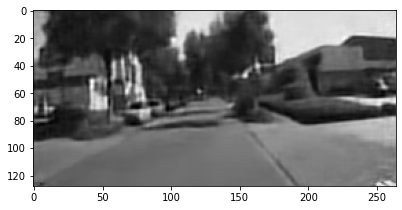

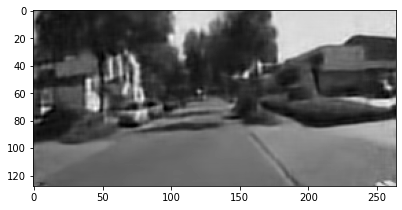

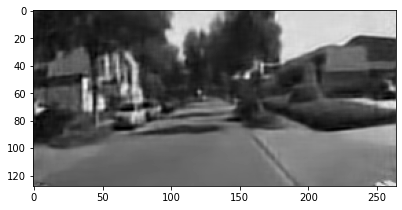

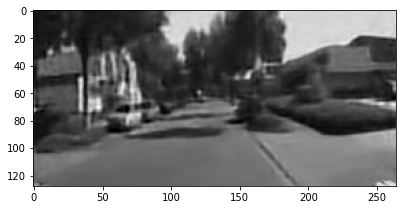

D_loss_fake1: 0.34659177
D_loss_fake11: 0.346605
Dicriminator prediction for fake images  [[0.50001794]
 [0.50000453]
 [0.5000095 ]
 [0.500006  ]]
PRediction for GAN predictions of fake images are  [[0.5000033 ]
 [0.5000109 ]
 [0.50001407]
 [0.50001174]]
G_loss: 0.34656864
>1, 1/113, d1=0.347, d2=0.347 g=0.347
27
(4, 128, 264, 1) (4,)
D_loss1: 0.34656036
D_loss11: 0.34656537
Discriminator prediction for real images  [[0.50002426]
 [0.50002426]
 [0.50003016]
 [0.5000278 ]]
Predicted Output for the sequence is 
Predicted Output for the sequence is 


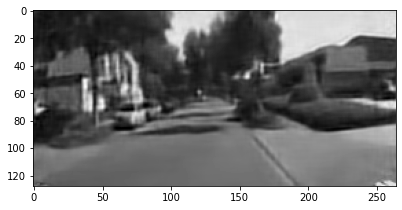

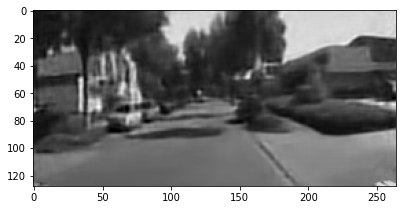

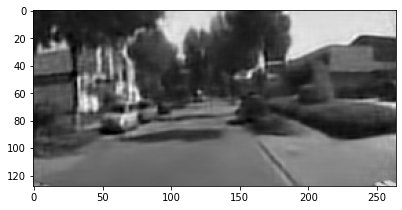

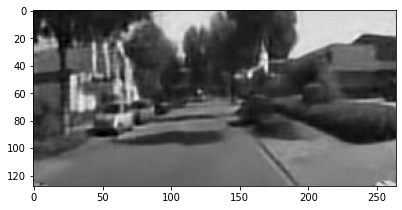

D_loss_fake1: 0.3465945
D_loss_fake11: 0.34659415
Dicriminator prediction for fake images  [[0.50000846]
 [0.5000077 ]
 [0.5000131 ]
 [0.5000177 ]]
PRediction for GAN predictions of fake images are  [[0.5000181 ]
 [0.50001454]
 [0.5000143 ]
 [0.5000048 ]]
G_loss: 0.3465647
>1, 2/113, d1=0.347, d2=0.347 g=0.347
14
(4, 128, 264, 1) (4,)
D_loss1: 0.3465714
D_loss11: 0.34657067
Discriminator prediction for real images  [[0.5000265 ]
 [0.50002515]
 [0.50000906]
 [0.5000097 ]]
Predicted Output for the sequence is 
Predicted Output for the sequence is 


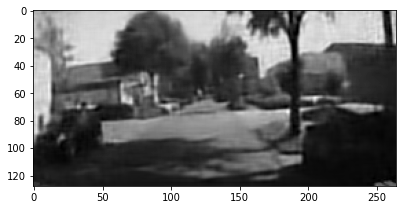

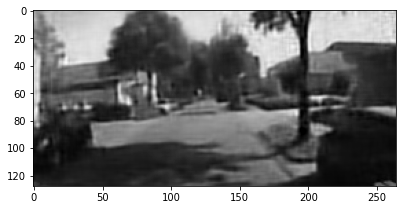

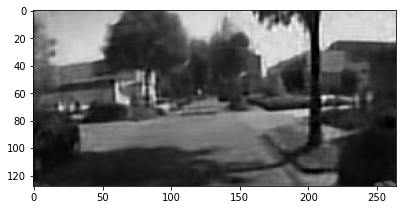

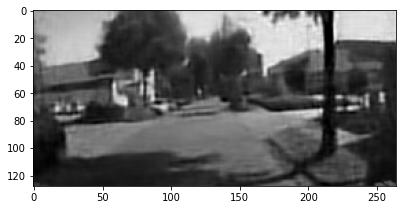

D_loss_fake1: 0.3465879
D_loss_fake11: 0.34658027
Dicriminator prediction for fake images  [[0.5000127 ]
 [0.50000495]
 [0.49999928]
 [0.4999898 ]]
PRediction for GAN predictions of fake images are  [[0.5000285]
 [0.5000334]
 [0.5000271]
 [0.5000183]]
G_loss: 0.34655648
>1, 3/113, d1=0.347, d2=0.347 g=0.347
45
(4, 128, 264, 1) (4,)
D_loss1: 0.34656626
D_loss11: 0.34656236
Discriminator prediction for real images  [[0.5000065 ]
 [0.50002867]
 [0.50003594]
 [0.50002766]]
Predicted Output for the sequence is 
Predicted Output for the sequence is 


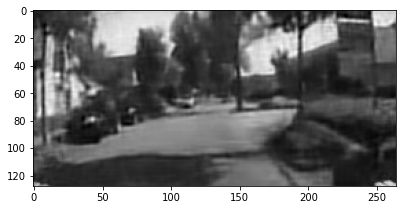

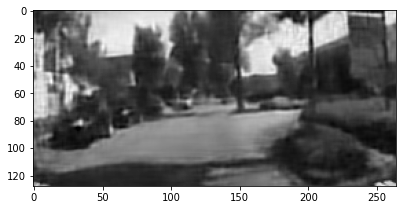

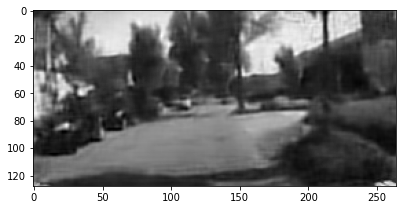

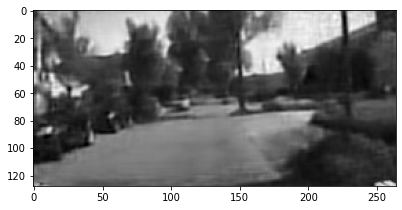

D_loss_fake1: 0.34659743
D_loss_fake11: 0.34659296
Dicriminator prediction for fake images  [[0.49999553]
 [0.5000196 ]
 [0.500016  ]
 [0.5000165 ]]
PRediction for GAN predictions of fake images are  [[0.5000177 ]
 [0.50001264]
 [0.50001043]
 [0.5000107 ]]
G_loss: 0.3465658
>1, 4/113, d1=0.347, d2=0.347 g=0.347
3
(4, 128, 264, 1) (4,)
D_loss1: 0.34654132
D_loss11: 0.34657294
Discriminator prediction for real images  [[0.5000564 ]
 [0.50005144]
 [0.5000585 ]
 [0.5000383 ]]
Predicted Output for the sequence is 
Predicted Output for the sequence is 


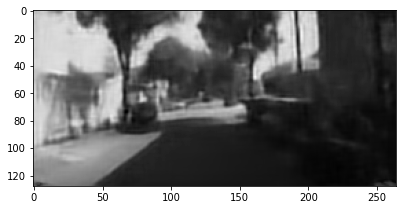

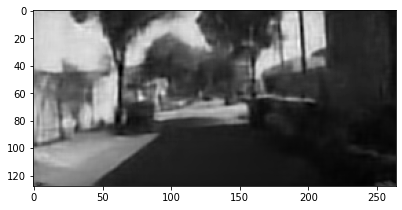

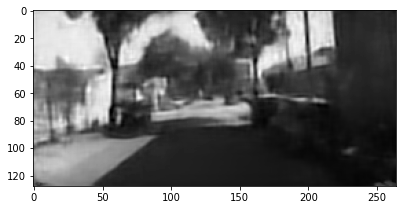

In [ ]:

in_src = Input(shape = ((64, 174, 1024)))
#gan_model=define_gan(gen(input_concatenated),call_disc(input_img_disc),input_concatenated)
#Train the GAN
discriminator,generator,gan_model,history=train(auto_encoder,call_disc(input_img_disc),call_gan(auto_encoder,call_disc(input_img_disc),input_img1,input_img2,input_img3,input_img4),Xtrain)

In [ ]:
# pred =generator.predict([train_x1,train_x2,train_x3,train_x4])

In [ ]:
for i in range(0,4):
    plt.figure(figsize=(100, 100))
    plt.subplot(2,13,1)
    plt.imshow(pred[(i),...,0],cmap='gray')
    plt.show()

In [ ]:
def _plot_loss( history):
        hist = pd.DataFrame(history)
        plt.figure(figsize=(20,5))
        plt.ylim(0,0.8)
        plt.title("Graph of loss for 100 Epochs of GAN training , learning rate = 0.00005 for generator and 0.0002 for discriminator")
        for colnm in hist.columns:
            plt.plot(hist[colnm],label=colnm)
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("iterations")
        plt.show()

In [ ]:
import pandas as pd
_plot_loss(history)

In [ ]:
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
#Define the metrics to find performance of the model
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
def compare_images(imageA, imageB, title,X_train):
	# compute the mean squared error and structural similarity

	for i in range(4):
		m = mse(imageA[i], imageB[i])
		s = measure.compare_ssim(imageA[i], imageB[i],multichannel=True)
		print("Input sequence is")
		plt.figure(figsize=(100, 100))
		for j in range(i,i+4):
			plt.subplot(2,13,j+1)
			plt.imshow(X_train[j,...,0],cmap='gray')
		plt.show()
		# plt.suptitle("MSE: %.4f, SSIM: %.4f" % (m, s))
	# show first image
		print("Predicted Frame is -")
		plt.figure(figsize=(100, 100))
		plt.subplot(2,13,j+1)
		plt.title("MSE: %.4f, SSIM: %.4f" % (m, s))
		plt.imshow(imageA[i,...,0],cmap='gray')
		plt.show()
	# show the second image
		print("Original Frame is -")
		plt.figure(figsize=(100, 100))
		plt.subplot(2,13,j+1)
		plt.imshow(imageB[i,...,0],cmap='gray')	

	# show the images
		plt.show()

In [ ]:
X_real=Xtrain[4:9]
pred=pred[:5]
X_train=Xtrain[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Input sequence is


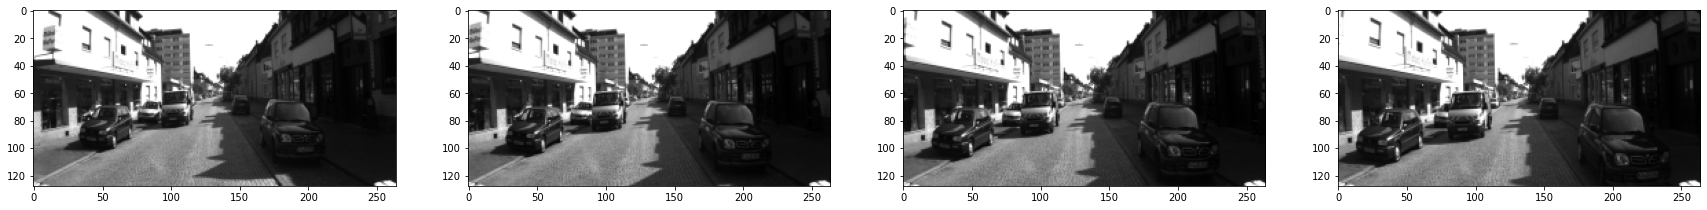

Predicted Frame is -


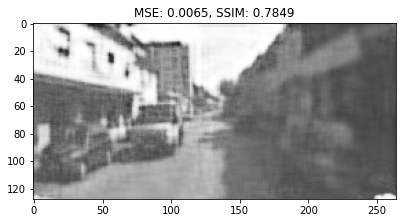

Original Frame is -


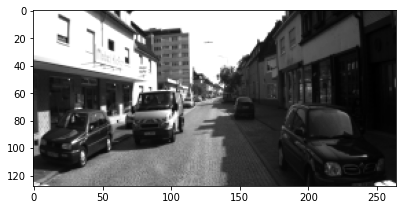

Input sequence is


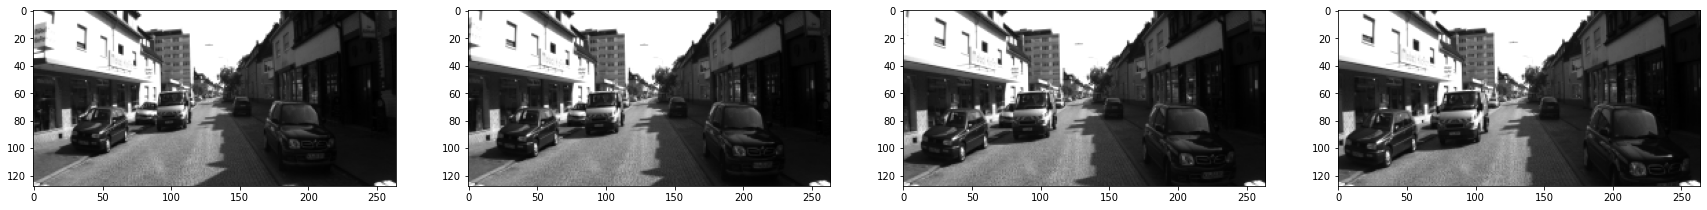

Predicted Frame is -


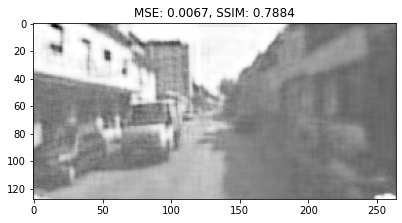

Original Frame is -


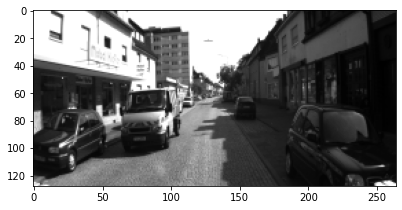

Input sequence is


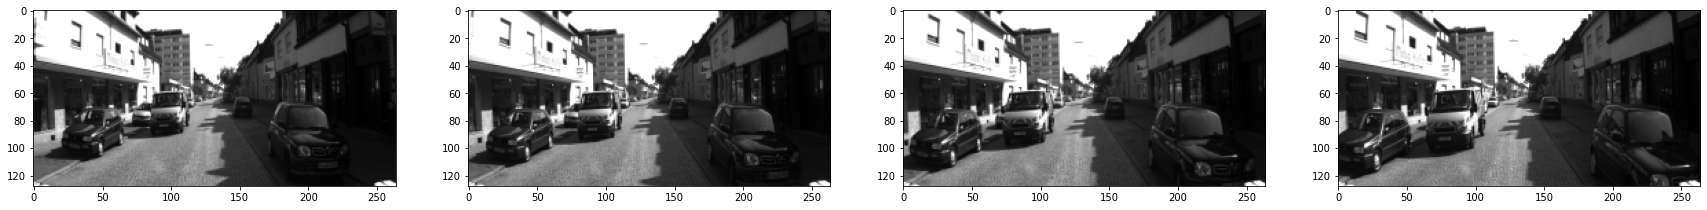

Predicted Frame is -


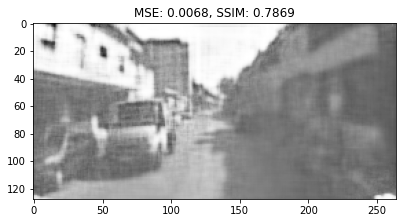

Original Frame is -


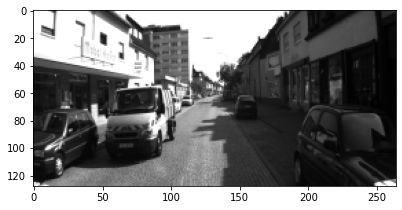

Input sequence is


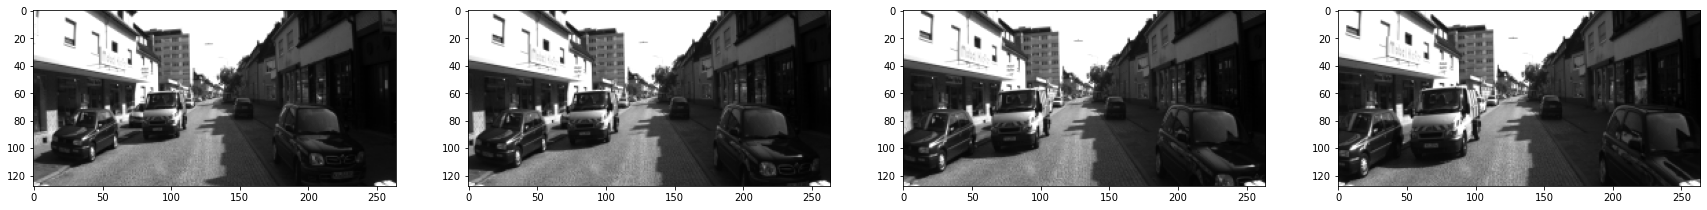

Predicted Frame is -


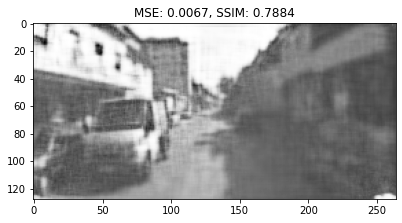

Original Frame is -


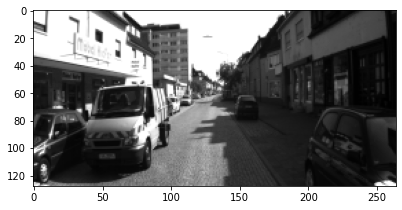

In [ ]:
compare_images(pred,X_real,"hello",X_train)